In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import tensorflow as tf

2025-11-03 11:07:30.144991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762168050.475085      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762168050.558263      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df=pd.read_csv("/kaggle/input/weather/seattle-weather.csv")

In [4]:
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [6]:
df.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


In [7]:
df.date.dtype

dtype('O')

In [8]:
df.date=pd.to_datetime(df.date)

In [9]:
df=df.sort_values(by='date')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='date', ylabel='temp_max'>

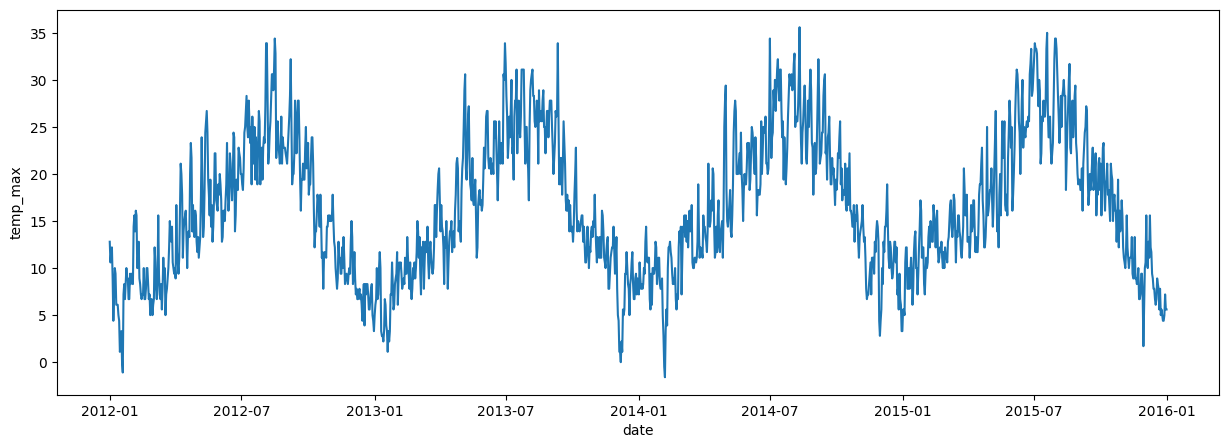

In [10]:
plt.figure(figsize=(15,5))
sns.lineplot(x='date',y='temp_max',data=df)

In [11]:
df.shape

(1461, 6)

In [12]:
df.isnull().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [13]:
df.duplicated().sum()

0

In [14]:
training_set=df.iloc[:,2:3].values
training_set

array([[12.8],
       [10.6],
       [11.7],
       ...,
       [ 7.2],
       [ 5.6],
       [ 5.6]])

In [17]:
features = ['precipitation', 'temp_max', 'temp_min', 'wind']
X = df[features].values
y = df['weather'].values

scaler = MinMaxScaler()
X = scaler.fit_transform(X)


label_enc = LabelEncoder()
y = label_enc.fit_transform(y)


y = tf.keras.utils.to_categorical(y)

def create_sequences(X, y, window=7):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i + window])
        y_seq.append(y[i + window])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 7  
X_seq, y_seq = create_sequences(X, y, sequence_length)


split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]


model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, activation='tanh'),
    tf.keras.layers.SimpleRNN(32, activation='tanh'),
    tf.keras.layers.Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=1)


loss, acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", acc)


pred = model.predict(X_test[:1])
print("Predicted Weather:", label_enc.inverse_transform([np.argmax(pred)]))
print("Actual Weather:", label_enc.inverse_transform([np.argmax(y_test[0])]))

Epoch 1/30


2025-11-03 11:08:07.275561: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4584 - loss: 1.2856 - val_accuracy: 0.2991 - val_loss: 1.4431
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5455 - loss: 1.0841 - val_accuracy: 0.4872 - val_loss: 1.3372
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5689 - loss: 1.0366 - val_accuracy: 0.4701 - val_loss: 1.3613
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6027 - loss: 1.0117 - val_accuracy: 0.4701 - val_loss: 1.3767
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5755 - loss: 0.9893 - val_accuracy: 0.5043 - val_loss: 1.3814
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5825 - loss: 1.0084 - val_accuracy: 0.4701 - val_loss: 1.4154
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5847 - loss: 0.9826 - val_accuracy: 0.5043 - val_loss: 1.4243
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5902 - loss: 0.9753 - val_accuracy: 0.4957 - val_loss: 1.3409
Ep

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


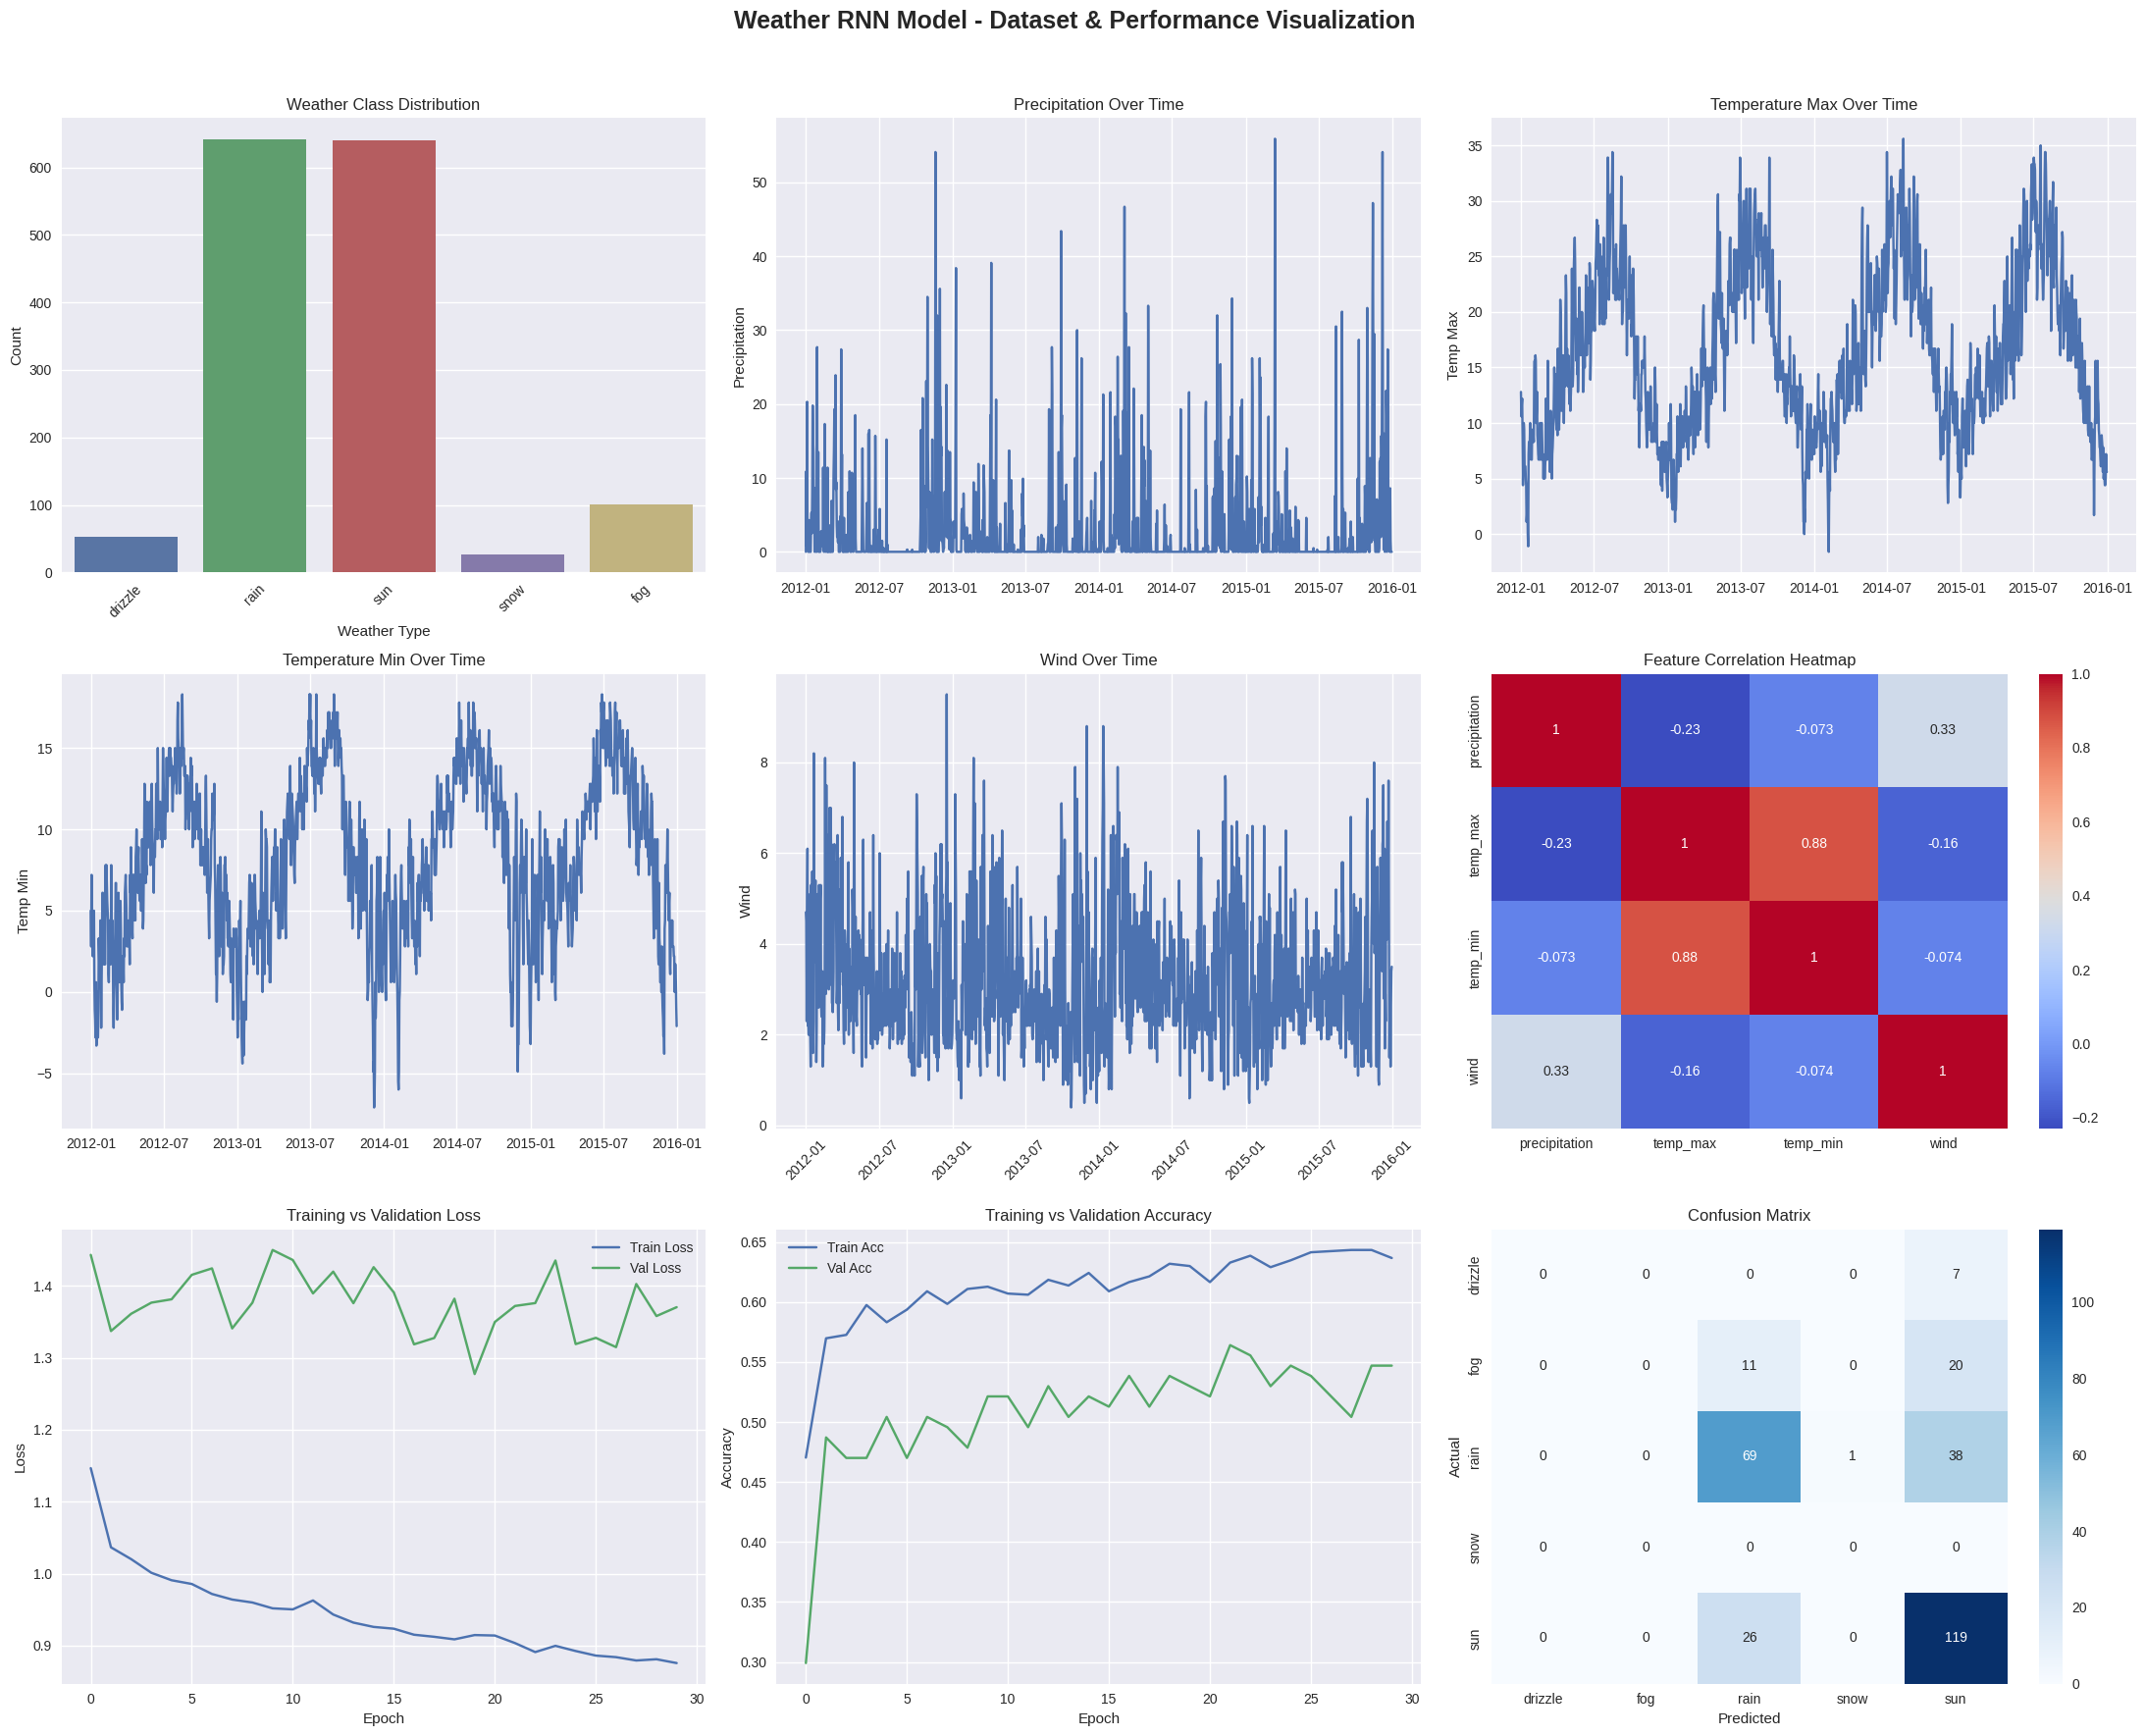


Classification Report:

              precision    recall  f1-score   support

     drizzle       0.00      0.00      0.00         7
         fog       0.00      0.00      0.00        31
        rain       0.65      0.64      0.64       108
        snow       0.00      0.00      0.00         0
         sun       0.65      0.82      0.72       145

    accuracy                           0.65       291
   macro avg       0.26      0.29      0.27       291
weighted avg       0.56      0.65      0.60       291



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

plt.style.use("seaborn-v0_8")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create figure
fig = plt.figure(figsize=(22, 18))
fig.suptitle("Weather RNN Model - Dataset & Performance Visualization", fontsize=18, fontweight="bold")

# 1️⃣ Class Distribution
ax1 = plt.subplot(3, 3, 1)
sns.countplot(x=df['weather'], ax=ax1)
ax1.set_title("Weather Class Distribution")
ax1.set_xlabel("Weather Type")
ax1.set_ylabel("Count")
ax1.tick_params(axis='x', rotation=45)

# 2️⃣ Precipitation Trend
ax2 = plt.subplot(3, 3, 2)
ax2.plot(df['date'], df['precipitation'])
ax2.set_title("Precipitation Over Time")
ax2.set_ylabel("Precipitation")

# 3️⃣ Temperature Max Trend
ax3 = plt.subplot(3, 3, 3)
ax3.plot(df['date'], df['temp_max'])
ax3.set_title("Temperature Max Over Time")
ax3.set_ylabel("Temp Max")

# 4️⃣ Temperature Min Trend
ax4 = plt.subplot(3, 3, 4)
ax4.plot(df['date'], df['temp_min'])
ax4.set_title("Temperature Min Over Time")
ax4.set_ylabel("Temp Min")

# 5️⃣ Wind Trend
ax5 = plt.subplot(3, 3, 5)
ax5.plot(df['date'], df['wind'])
ax5.set_title("Wind Over Time")
ax5.set_ylabel("Wind")
ax5.tick_params(axis='x', rotation=45)

# 6️⃣ Feature Correlation Heatmap
ax6 = plt.subplot(3, 3, 6)
sns.heatmap(df[features].corr(), annot=True, cmap="coolwarm", ax=ax6)
ax6.set_title("Feature Correlation Heatmap")

# 7️⃣ Training Loss
ax7 = plt.subplot(3, 3, 7)
ax7.plot(history.history['loss'], label='Train Loss')
ax7.plot(history.history['val_loss'], label='Val Loss')
ax7.set_title("Training vs Validation Loss")
ax7.set_xlabel("Epoch")
ax7.set_ylabel("Loss")
ax7.legend()

# 8️⃣ Training Accuracy
ax8 = plt.subplot(3, 3, 8)
ax8.plot(history.history['accuracy'], label='Train Acc')
ax8.plot(history.history['val_accuracy'], label='Val Acc')
ax8.set_title("Training vs Validation Accuracy")
ax8.set_xlabel("Epoch")
ax8.set_ylabel("Accuracy")
ax8.legend()

# 9️⃣ Confusion Matrix
ax9 = plt.subplot(3, 3, 9)
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=label_enc.classes_,
            yticklabels=label_enc.classes_,
            cmap="Blues",
            ax=ax9)
ax9.set_title("Confusion Matrix")
ax9.set_xlabel("Predicted")
ax9.set_ylabel("Actual")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for main title
plt.show()

# Print classification report below plots
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=label_enc.classes_))
